# Demonstration Model

In this model we will add object detection to our Semantic Segmentation model, using the YOLOv3 architecture. Training this model is a monumental task, that is beyond the scope of the computational resources available to me so I will use a pretrained model.

The detection model I am using was obtained from the code examples of 'Hands on Computer Vision with Tensorflow 2' by Eliot Andres and Benjamin Planche available at https://www.packtpub.com/application-development/hands-computer-vision-tensorflow-2. 

The book was also very useful to develop the skills required to do this project.

The weights used here were trained by the creator of the YOLOv3 architecture Joseph Redmon. More information about the model can be found here https://pjreddie.com/darknet/yolo/


I then combine the output obtained from the detection model with my Semantic Segmentation model to obtain an output.

In [1]:
# Imports

import time
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import numpy as np
import tensorflow as tf
from models import YoloV3
from utils import draw_outputs, transform_images
import matplotlib.pyplot as plt
import os
import json
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from semantic_segmentation import unet, onehot_to_rgb

Please enter the name of the image file below

In [2]:
filename = '2pi-nHAei9kOMF1tGII6wg.jpg'

Make sure IMG_DIR is set to the correct location. Use the first option (*demo_images* )for downloaded images and the second option to access the Mapillary Test Images.

In [3]:
# Setting variables
CLASSES_PATH = './coco.names'
YOLO_WEIGHTS_PATH = './yolo_weights/yolov3.tf'
UNET_WEIGHTS_PATH = './unet_weights/mapillary_full_dataset_weights.h5'
MAPILLARY_DATASET = '/home/anupjsebastian/mapillary_dataset/'
# IMG_DIR = './demo_images' # For Downloaded Images
IMG_DIR = os.path.join(MAPILLARY_DATASET, 'testing', 'images')  # For Mapillary Test Images
img_width = 256
img_height = 256
batch_size = 5
IMAGE_SIZE = 416

In [4]:
# Obtaining Image Metadata

config = os.path.join(MAPILLARY_DATASET, 'config.json')

with open(config) as config_file:
    config = json.load(config_file)

labels = config['labels']
num_categories = len(labels)
label_names = [label['readable'] for label in labels]
label_colors = [label['color'] for label in labels]
id_to_color = {ID:tuple(color) for ID, color in enumerate(label_colors)}
color_to_id = {tuple(color):ID for ID, color in enumerate(label_colors)}

In [5]:
# Defining Models

yolo = YoloV3()
yolo.load_weights(YOLO_WEIGHTS_PATH)
class_names = [c.strip() for c in open(CLASSES_PATH).readlines()]

unet = unet(n_filters = num_categories)
unet.load_weights(UNET_WEIGHTS_PATH)

Input Shape: Tensor("input_11:0", shape=(None, 256, 256, 3), dtype=float32)


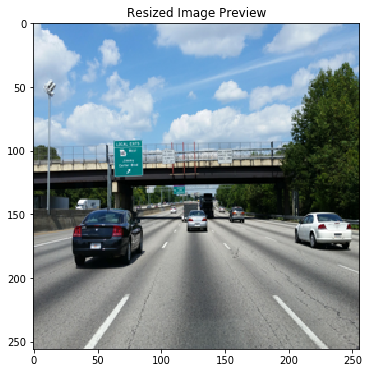

In [6]:
# Opening and Previewing Images

img = Image.open(os.path.join(IMG_DIR, filename)).resize((img_width, img_height))
img = tf.convert_to_tensor(np.array(img))
plt.figure(figsize = (6,6))
plt.imshow(img)
plt.title('Resized Image Preview')

input_img = tf.expand_dims(img, 0)
input_img = transform_images(input_img, IMAGE_SIZE)

In [7]:
# Defining a few useful functions

def detect_objects(model, image):
    boxes, scores, classes, nums = yolo(image)
    logging.info('detections:')
    
    for i in range(nums[0]):
        print('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                           np.array(scores[0][i]),
                                           np.array(boxes[0][i])))

    prediction_img = draw_outputs(img.numpy(), (boxes, scores, classes, nums), class_names)
    return prediction_img

def get_masks(model, image, conversion_map):
    shape = np.array(image).shape
    pred = unet.predict(np.reshape(image, (1,*shape)))
    pred = onehot_to_rgb(pred[0],conversion_map)
    return pred

def plot_outputs(image, unet, yolo, conversion_map):
    
    input_img = tf.expand_dims(image, 0)
    input_img = transform_images(input_img, IMAGE_SIZE)
    
    yolo_pred = detect_objects(yolo, input_img)
    
    unet_pred = get_masks(unet, image/255, conversion_map)
    
    fig = plt.figure(figsize=(20,8))

    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(image)
    ax1.title.set_text('Actual Image')


    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Semantic Segmentation')
    ax2.imshow(unet_pred)

    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Object Detection')
    ax3.imshow(yolo_pred)

    plt.show()

	car, 0.9966713786125183, [0.46921656 0.57361037 0.5330024  0.6362049 ]
	car, 0.9792103171348572, [0.7974892  0.57246554 0.98673195 0.69727695]
	car, 0.963476836681366, [0.11856896 0.57682467 0.3320825  0.74912167]
	car, 0.9188107252120972, [0.59995365 0.56357265 0.6499114  0.6152185 ]
	car, 0.8968004584312439, [0.41917944 0.5676363  0.44418156 0.5901515 ]
	car, 0.683778703212738, [0.56664467 0.56613785 0.599445   0.5923328 ]


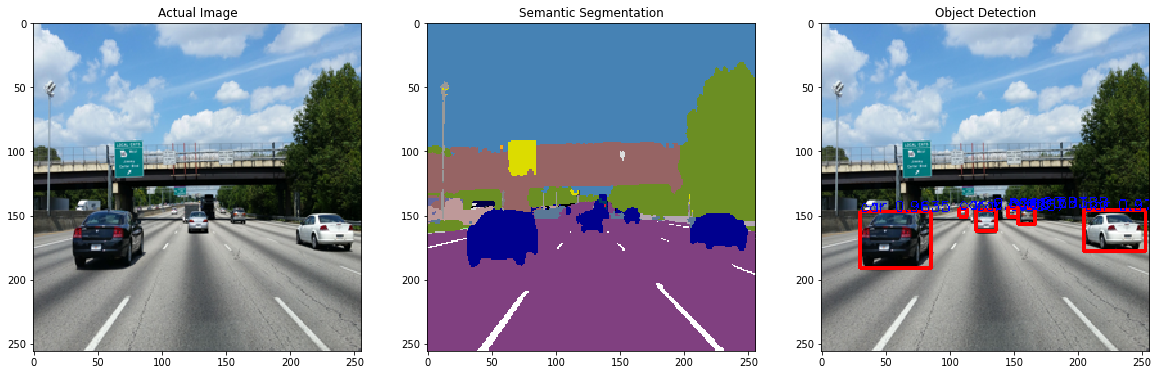

In [10]:
plot_outputs(img, unet, yolo, id_to_color)